# load llc uplet parcel simulation and build zarr file with all data

In [1]:
import os
from glob import glob

import numpy as np
import pandas as pd
import xarray as xr

%matplotlib inline
from matplotlib import pyplot as plt

import mitequinox.utils as ut
import mitequinox.parcels as pa

In [2]:
from dask.distributed import Client, LocalCluster
if True:
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster()
    w = cluster.scale(jobs=10)
else:
    cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.101:8787/status,
Dashboard: http://10.148.0.101:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.101:50094,Workers: 0
Dashboard: http://10.148.0.101:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


---
## load data

In [3]:
#root_dir = '/home1/scratch/slgentil/parcels/'
root_dir = os.path.join(ut.work_data_dir,"parcels") 

#run_name = "global_dij8_up3_r1s111_15j"
#run_name = "global_dij8_up3_r2s111_15j"
#run_name = "global_dij8_up3_r1s111_30j_201202" # done
run_name = "global_dij8_up3_r1s111_30j_201205" # to be done

In [4]:
ds_info, dirs = pa.load_logs(root_dir, run_name)

#df_1d = pa.load_nc(dirs["run"], index='trajectory', step_tile="00*-*")

In [7]:
def load_nc_uplet_store(
    run_dir,
    out_dir,
    num_steps,
    step_limit=None,
    steps=None,
    ds_init=None,
    ):
    """load parcels netcdf uplet files, group uplets and store them as zarr
    """

    # find list of tile directories
    tile_run_dirs = sorted(glob(run_dir + "/data_*"))

    # load uplet initial info
    if ds_init is None:
        ds_init = _load_uplet_init(tile_run_dirs)
    
    # loop around multiple steps
    if not isinstance(steps, int):
        if steps is None:
            steps = list(range(num_steps))
        for s in steps:
            load_nc_uplet_store(run_dir, out_dir, num_steps, steps=s, ds_init=ds_init)
        return steps

    # find list of netcdf float files
    float_files = []
    for _dir in tile_run_dirs:
        float_files.extend(sorted(glob(_dir + f"/floats_{steps:03d}_*.nc")))
        
    # load drifter data
    def _prep(ds):
        ds = _filter_parcels_data(ds, delta_time)
        ds["trajectory"] = ds["trajectory"].astype("int32")
        ds = (ds.assign_coords(traj=ds.trajectory.isel(time=0, drop=True))
              .drop(["trajectory"])
             )
        return ds
    
    #for nc in float_files:
    ds = xr.open_mfdataset(float_files, combine="nested", concat_dim="traj", preprocess=_prep,)
    
    # persist, necessary?
    #ds = ds.persist()
    ds = ds.compute() # better?, seems like it
    
    # select full uplets
    dr_id = ds.traj
    dr_id_uplet = ds_init.id

    # there are no index in dr_id that are not dr_id_uplet:
    #np.setdiff1d(dr_id, dr_id_uplet).size # =0
    # index in dr_id_uplet but not in dr_id
    #np.setdiff1d(dr_id_uplet, dr_id) # about 10000 values !

    bad_uplet = np.setdiff1d(dr_id_uplet, dr_id)
    ds_init = ds_init.where( (~ds_init.id.isin(bad_uplet)).all("item"), drop=True )
    ds_init["id"] = ds_init["id"].astype(int)

    #dr_id_uplet = ds_init.id.compute() # should be computed already
    #np.setdiff1d(dr_id_uplet, dr_id) # empty

    ds_up = (xr.concat([ds.sel(traj=ds_init.sel(item=i).id).reset_coords("traj") 
                        for i in ds_init.item
                       ],
                       "item",
                      )
         .chunk(dict(item=-1, time=-1, uplet="auto"))
        )
    ds_up = ds_up.assign_coords(**{v+"_init_uplet": ds_init[v].mean("item") for v in ["lon", "lat"]})
    
    ds_up.to_zarr(os.path.join(out_dir, f"uplet_{steps:03d}.zarr"), mode="w")
    
    return steps

def _load_uplet_init(tile_run_dirs, compute=True):
    """ load initial uplets along with positions"""
    
    _D = []
    for i, _dir in enumerate(tile_run_dirs):
        _ds = xr.open_dataset(os.path.join(_dir, "floats_init_uplet.nc"))
        #print(_ds["uplet"].size) # values do not exceed 6000
        _ds["uplet"] = int(i*1e6) + np.arange(_ds["uplet"].size)
        _D.append(_ds)
    ds_init = xr.concat(_D, "uplet")
    if compute:
        ds_init = ds_init.compute()

    return ds_init

def _filter_parcels_data(ds, delta_time):
    """ get rid of NaNs, time outside a delta_time window
    """

    # drop NaNs
    df = ds.to_dataframe().dropna() 
    # filter out times outside the window
    tmax = df.time.min() + delta_time
    df = df[df.time<tmax]

    # set traj and time as index, drop duplicated values and convert back to xarray
    df = df.reset_index().set_index(["traj", "time"])
    # all duplicates correspond to different obs but all other variables equal (including traj and time)
    #df[df.index.duplicated(keep=False)]
    #
    ds = df[~df.index.duplicated(keep="first")].to_xarray()
    
    return ds

In [8]:
run_dir = dirs["run"]
out_dir = dirs["parquets"]
#out_dir = "/home1/scratch/aponte/llc4320_lagrangian" # tmp while file are beeing copied
num_steps = ds_info.step.size
delta_time = pd.Timedelta("24H")
#steps=[0,1]
#steps=0
steps=None

In [9]:
load_nc_uplet_store(
    run_dir,
    out_dir,
    num_steps,
    delta_time,
    steps=steps,
    )

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29]

### combine different runs

In [5]:
zarrs = sorted(glob(os.path.join(dirs["parquets"], f"uplet_*.zarr")))
# delete all uplet_*.zarr files once this is finished
#zarrs = sorted(glob(os.path.join("/home1/scratch/aponte/llc4320_lagrangian", f"uplet_*.zarr"))) # tmp while file are beeing copied

ds = xr.concat([xr.open_zarr(zarr) for zarr in zarrs], "time", join="outer", coords="minimal", compat="no_conflicts")

# fix types
for v in ds:
    ds[v] = ds[v].astype(np.float32)
ds["traj"] = ds["traj"].astype(int)
ds["obs"] = ds["obs"].astype(int)

# dev
#ds = ds.isel(uplet=slice(0,1000)).chunk(dict(uplet=100))
#ds = ds.persist()

In [6]:
# add local projection and compute center of mass
import pyproj

def add_mass_center(lon, lat):
    # center of mass
    lonc, latc = lon[0,0], lat[0,0]
    proj = pyproj.Proj(proj="aeqd", lat_0=latc, lon_0=lonc, datum="WGS84", units="m")
    x, y = proj.transform(lon, lat)
    # average along item
    x_m, y_m = x.mean(axis=0), y.mean(axis=0)
    lon_m, lat_m = proj.transform(x_m, y_m, 
                                  direction=pyproj.enums.TransformDirection.INVERSE,
                                 )
    return x, y, lon_m, lat_m

#ds = ds.chunk(dict(time=-1))
ds["x"], ds["y"], ds["lon_m"], ds["lat_m"] = \
    xr.apply_ufunc(add_mass_center, 
                   ds.lon.chunk(dict(time=-1)), ds.lat.chunk(dict(time=-1)), 
                   input_core_dims=[["item", "time"]]*2,
                   output_core_dims=[["item", "time"]]*2+[["time"]]*2,
                   vectorize=True, 
                   dask="parallelized",
                   output_dtypes=[float]*4,
                   dask_gufunc_kwargs=dict(output_sizes=dict(item=ds.item.size, time=ds.time.size)),
                  )

ds["x_m"] = ds.x.mean("item")
ds["y_m"] = ds.y.mean("item")
ds["dl"] = np.sqrt( (ds.x-ds.x_m)**2 + (ds.y-ds.y_m)**2)
ds["dl_uplet"] = ds.dl.mean("item") #.isel(obs=-1) #.plot.scatter()

ds = ds.persist()

In [7]:
# store result in zarr file
ds = ds.chunk(dict(item=-1, time="auto", uplet="auto"))

for v in ds:
    if "chunks" in ds[v].encoding:
        del ds[v].encoding["chunks"]

#_zarr = os.path.join("/home1/scratch/aponte/llc4320_lagrangian", "uplet.zarr") # tmp while file are beeing copied
_zarr = os.path.join(dirs["parquets"], "uplet.zarr")
ds.to_zarr(_zarr, mode="w")

---

## reload and inspect

In [42]:
# reload
ds = xr.open_zarr(os.path.join(dirs["parquets"], "uplet.zarr")).persist()

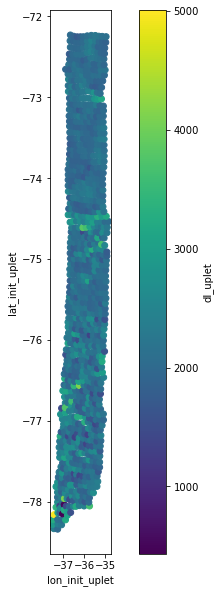

In [19]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ds.isel(obs=-1).plot.scatter(x="lon_init_uplet", y="lat_init_uplet", hue="dl_uplet")
ax.set_aspect(1/np.cos(-75*np.pi/180))

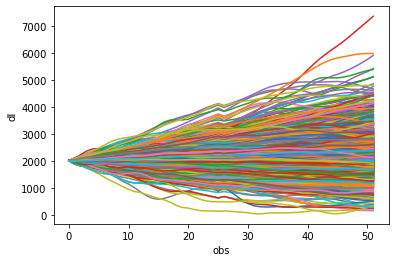

In [89]:
ds.dl.stack(drifter=("item","uplet")).plot.line(x="obs", add_legend=False);

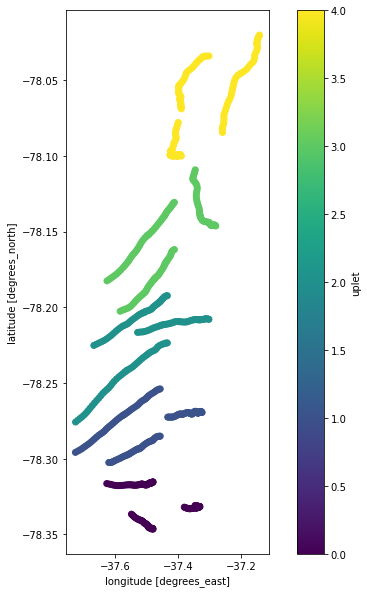

In [22]:
_ds = ds.isel(uplet=slice(0,5))
fig, ax = plt.subplots(1,1, figsize=(10,10))
_ds.plot.scatter(x="lon", y="lat", hue="uplet")
ax.set_aspect(1/np.cos(-78*np.pi/180))

## Close cluster

In [8]:
cluster.close()

In [ ]:

# tmp - test
root_dir = "/home/datawork-lops-osi/equinox/mit4320/parcels/global_dij8_up3_r1s111_30j_201202/run/data_033"
nc_files = sorted(glob(os.path.join(root_dir, "floats_???_033.nc")))
for nc in nc_files:
    ds = xr.open_dataset(nc)
    print(str(ds["time"].values[0,0]), str(ds["time"].values[0,-1]))
  
nc = nc_files[0]
ds = xr.open_dataset(nc)
ds